<a href="https://colab.research.google.com/github/adarshmodh/Deep-Learning-Assignments/blob/master/YOLO_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'.

This also downloads 2 npz files for your use: labels.npz and images.npz. For those not using colab you can download manually here:

https://drive.google.com/open?id=1jIKQLhTHZUE6m2mE5lRKMSqN7ZGK2Gyu

https://drive.google.com/open?id=1Gth_AVG5t-4ZhH_whOaXwe0PBXNhIIK0


In [196]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW2')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split(/)
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())

id_to_fn = {
    '1Gth_AVG5t-4ZhH_whOaXwe0PBXNhIIK0': 'labels.npz',
    '1jIKQLhTHZUE6m2mE5lRKMSqN7ZGK2Gyu': 'images.npz'
           }

# download all files into the vm
for fid, fn in id_to_fn.items():
    download_file(fn, fid)

# PyTorch Dataset

Here you will implement a simple pytorch dataset that loads the images and labels as describe in the PDF.

In [0]:
# torch and torchvision imports
import torch
from torchvision import datasets, transforms
from sklearn.metrics import jaccard_score as jsc
from sklearn.model_selection import train_test_split
import numpy as np
from pathlib import Path

class HW2Dataset(torch.utils.data.Dataset):
  def __init__(self, path,transform):
    self.path = path
    images_data = np.load(path /'images.npz')['arr_0']
    labels_data = np.load(path /'labels.npz',allow_pickle=True,encoding='bytes')['arr_0']
    self.count = len(images_data)
    self.transform = transform
    self.images_data = images_data
    self.labels_data = labels_data
    self.num_channels = 8
    self.patch_size = 16
    # self.train_data, self.test_data, self.train_labels, self.test_labels = train_test_split(images_data, labels_data, test_size=0.3, random_state=42)
    # print(self.label_data)

  def __getitem__(self, index):
    transform = self.transform 
    image = self.images_data[index]
    transformed_label = self.process_label(self.labels_data[index],image.shape,self.patch_size,self.num_channels)
    return transform(image),transformed_label
  
  def process_label(self,labels,image_shape,patch_size,num_channels):
    grid_size = [int(image_shape[0]/patch_size),int(image_shape[1]/patch_size), num_channels]
    # grid_size.append(num_channels)
    transformed_label = torch.zeros(grid_size)
    for label in labels:
      p,x1,y1,x2,y2 = label
      label_box_center = np.array([(x2+x1)/2,(y2+y1)/2])
      # print(label_box_center)
      label_associated_grid = np.floor(label_box_center/patch_size).astype(int)
      
      transformed_label[label_associated_grid[0],label_associated_grid[1],0] = 1.0    #P(objectness)
      transformed_label[label_associated_grid[0],label_associated_grid[1],1] = (label_box_center[0] - patch_size*label_associated_grid[0])/patch_size  #x
      transformed_label[label_associated_grid[0],label_associated_grid[1],2] = (label_box_center[1] - patch_size*label_associated_grid[1])/patch_size  #y
      transformed_label[label_associated_grid[0],label_associated_grid[1],3] = (x2-x1)/image_shape[0] #w
      transformed_label[label_associated_grid[0],label_associated_grid[1],4] = (y2-y1)/image_shape[1] #h
      transformed_label[label_associated_grid[0],label_associated_grid[1],5+p.astype(int)] = 1.0 #P(class)

      # print(transformed_label[label_associated_grid[0],label_associated_grid[1],:])

    return transformed_label

  def __len__(self):
    count = self.count
    return count # number of images

In [321]:
# Create test and train datasets
torch.manual_seed(0)

#!!!!!!!!!!change to wherever YOLO data is located
data_folder = Path("/content/gdrive/My Drive/CIS680_2019/HW2")

red = (255,0,0) #pedestrian
green = (0,255,0) #car
blue = (0,0,255) #traffic signal

normalize = transforms.Normalize(mean=[0.0],std=[1.0])
transform = transforms.Compose(
        [transforms.ToTensor(),normalize])

dataset = HW2Dataset(data_folder, transform)

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])
print(len(trainset),len(testset))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True)
sample_testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)


6999 3000


# Checking the original Labels

Text(0.5, 1.0, 'original bounding boxes from input labels')

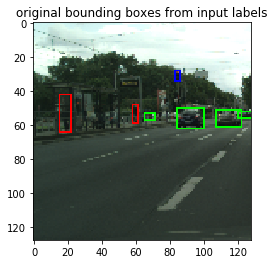

In [180]:
import matplotlib.pyplot as plt
import cv2
import random

image_data = np.load(data_folder / "images.npz")['arr_0']  
label_data = np.load(data_folder / "labels.npz",allow_pickle=True,encoding='bytes')['arr_0'] 
# print(image_data[0])
# print(label_data[0].astype(np.uint8))

index = random.randint(0,len(image_data))

index = 1000
#clean sample 110
img = image_data[index]

for label in label_data[index]:
  p,x1,y1,x2,y2 = label.astype(np.uint8)
  # print("newbox")
  # print(x1,y1,x2,y2)
  if p==0:
    color = red
  elif p==1:
    color = blue
  elif p==2:
    color = green    
  
  center_x = int((x1+x2)/2)
  center_y = int((y1+y2)/2)
  # print(center_x,center_y)
  x = center_x%16
  y = center_y%16
  w = (x2-x1)/128
  h = (y2-y1)/128
  # print(x,y,w,h)
  cv2.rectangle(img, (x1, y1), (x2, y2), color, 1)

plt.imshow(img)
plt.title("original bounding boxes from input labels")


# Dataset test

We suggest coming up with a test for your dataset. This is laid out in bullet point 2 under section 6. Testing and confirming that all of this works as expected here will save you headache later.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pr(Objectness) = 1.0 ; x,y,w,h = [0.15625,0.3125,0.0546875,0.171875] ; Pr(pedestrian)=1.0, Pr(traffic_signal)=0.0, Pr(car)=0.0 
Pr(Objectness) = 1.0 ; x,y,w,h = [0.71875,0.34375,0.0234375,0.0859375] ; Pr(pedestrian)=1.0, Pr(traffic_signal)=0.0, Pr(car)=0.0 
Pr(Objectness) = 1.0 ; x,y,w,h = [0.25,0.4375,0.046875,0.03125] ; Pr(pedestrian)=0.0, Pr(traffic_signal)=0.0, Pr(car)=1.0 
Pr(Objectness) = 1.0 ; x,y,w,h = [0.28125,0.9375,0.0234375,0.046875] ; Pr(pedestrian)=0.0, Pr(traffic_signal)=1.0, Pr(car)=0.0 
Pr(Objectness) = 1.0 ; x,y,w,h = [0.75,0.5,0.125,0.09375] ; Pr(pedestrian)=0.0, Pr(traffic_signal)=0.0, Pr(car)=1.0 
Pr(Objectness) = 1.0 ; x,y,w,h = [0.15625,0.5,0.1171875,0.078125] ; Pr(pedestrian)=0.0, Pr(traffic_signal)=0.0, Pr(car)=1.0 


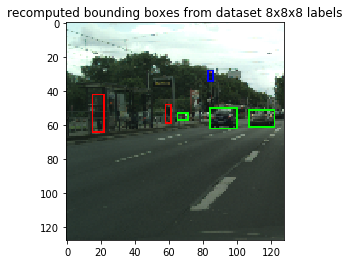

In [179]:
import matplotlib.pyplot as plt
import cv2
import random

original_gt_label_data = np.load(data_folder / "labels.npz",allow_pickle=True,encoding='bytes')['arr_0'] 

def IoU(label,output):
  label = label.cpu().numpy().reshape(-1)
  target = output.cpu().numpy().reshape(-1)
  iou = jsc(target,lbl)
  return iou


def plot_labels(image, tensor_label):
  patch_size = 16
  image_shape = [128,128]

  img = image.permute(1,2,0).numpy().copy()
  
  obj_indices = torch.nonzero(tensor_label[:,:,0]).numpy()
  labels = tensor_label.numpy()
  # print(labels.shape)
  for index in obj_indices:
    i,j = index
    # print(i,j)
    print("Pr(Objectness) = {} ; x,y,w,h = [{},{},{},{}] ; Pr(pedestrian)={}, Pr(traffic_signal)={}, Pr(car)={} ".format(labels[i,j,0],labels[i,j,1],labels[i,j,2],labels[i,j,3],labels[i,j,4],labels[i,j,5],labels[i,j,6], labels[i,j,7]))
    x,y,w,h = labels[i,j,1:5].copy()
    w = w*image_shape[0]
    h = h*image_shape[1]
    x = x*patch_size
    y = y*patch_size
    
    box_center_x = i*patch_size + x
    box_center_y = j*patch_size + y
    
    x1 = int(box_center_x - 0.5*w)
    y1 = int(box_center_y - 0.5*h)
    x2 = int(box_center_x + 0.5*w)
    y2 = int(box_center_y + 0.5*h)
    
    # print(box_center_x, box_center_y,x1,y1,x2,y2)

    if labels[i,j,5]==1:
      color = red
    elif labels[i,j,6]==1:
      color = blue
    elif labels[i,j,7]==1:
      color = green 
    # print(color)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 1)  
  
  plt.imshow(img)
  plt.title("recomputed bounding boxes from dataset 8x8x8 labels")


index = 1000

image,label = dataset[index]

plot_labels(image,label) 


# Model Definition

In [190]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

class YOLOish(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros')
    self.conv1_bn = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros')
    self.conv2_bn = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros')
    self.conv3_bn = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros')
    self.conv4_bn = nn.BatchNorm2d(256)
    self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros')
    self.conv5_bn = nn.BatchNorm2d(512)
    self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros')
    self.conv6_bn = nn.BatchNorm2d(1024)
    self.t_conv7 = nn.ConvTranspose2d(in_channels=1024, out_channels=256, kernel_size=4, stride=2, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros')
    self.t_conv7_bn = nn.BatchNorm2d(256)
    self.t_conv8 = nn.ConvTranspose2d(in_channels=256, out_channels=64, kernel_size=4, stride=2, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros')
    self.t_conv8_bn = nn.BatchNorm2d(64)
    self.conv9 = nn.Conv2d(in_channels=64, out_channels=8, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros')

  def forward(self, x):
    x = F.relu(self.conv1_bn(self.conv1(x)))
    x = F.relu(self.conv2_bn(self.conv2(x)))
    x = F.relu(self.conv3_bn(self.conv3(x)))
    x = F.relu(self.conv4_bn(self.conv4(x)))
    x = F.relu(self.conv5_bn(self.conv5(x)))
    x = F.relu(self.conv6_bn(self.conv6(x)))
    x = F.relu(self.t_conv7_bn(self.t_conv7(x)))
    x = F.relu(self.t_conv8_bn(self.t_conv8(x)))
    # x = F.relu(self.conv9(x))
    x = torch.sigmoid(self.conv9(x))
    return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = YOLOish().to(device)
print(model)


YOLOish(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv5_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv6_bn): BatchNorm2d(1024, eps=1e-05, moment

# Train your network

It might be good to save checkpoints and reload from the most recent. This is due to time constraints inside of colab.

Define Loss Function

In [0]:
#define loss function


def myloss_fn(pred_labels,gt_labels, lambda_coord, lambda_noobj):
  # batch_size = gt_labels.shape[0]
  # obj_indices = gt_labels[:,:,:,0].nonzero()
  # noobj_indices = (gt_labels[:,:,:,0]==0).nonzero()
  # # print(labels.shape)
  # loss = 0.0
  # for index in noobj_indices:
  #   i,j,k = index
  #   loss4 = (gt_labels[i,j,k,0] - pred_labels[i,j,k,0])**2  #false negative classification loss
  #   loss += lambda_noobj*loss4
  
  # for index in obj_indices:
  #   i,j,k = index
  #   # print(i,j,k)
  #   loss3 = (gt_labels[i,j,k,0] - pred_labels[i,j,k,0])**2 #false positive classification loss
  #   # loss += loss3
  #   # if(pred_labels[i,j,k,0]==1):
  #   x,y,w,h = gt_labels[i,j,k,1:5]
  #   xhat,yhat,what,hhat = pred_labels[i,j,k,1:5]
  #   loss1 = (x-xhat)**2 + (y-yhat)**2 #localization loss
  #   loss2 = (torch.sqrt(w) - torch.sqrt(what))**2 + (torch.sqrt(h) - torch.sqrt(hhat))**2 #localization loss  
  #   loss5 = torch.sum((gt_labels[i,j,k,5:8] - pred_labels[i,j,k,5:8])**2)
    
    # loss += lambda_coord*(loss1 + loss2) + loss3 + loss5

  grid_size = gt_labels.shape[1:3]
  batch_size = gt_labels.shape[0]
  loss = 0.0
  # print(grid_size,batch_size)
  for batch in range(batch_size):
    for i in range(grid_size[0]):
      for j in range(grid_size[1]):
        if(gt_labels[batch,i,j,0]==1):
          loss3 = (gt_labels[batch,i,j,0] - pred_labels[batch,i,j,0])**2 #false positive classification loss
          x,y,w,h = gt_labels[batch,i,j,1:5]
          xhat,yhat,what,hhat = pred_labels[batch,i,j,1:5]
          # print(x,y,xhat,yhat)
          # print(w,h,what,hhat)
          loss1 = (x-xhat)**2 + (y-yhat)**2 #localization loss
          loss2 = (torch.sqrt(w) - torch.sqrt(what))**2 + (torch.sqrt(h) - torch.sqrt(hhat))**2 #localization loss  
          loss5 = torch.sum((gt_labels[batch,i,j,5:8] - pred_labels[batch,i,j,5:8])**2) #class probability loss
          
          loss += lambda_coord*(loss1 + loss2) + loss5 + loss3
          # print("obj {},{},{},{}".format(lambda_coord*loss1,lambda_coord*loss2,loss3,loss5))
        elif(gt_labels[batch,i,j,0]==0):
          loss4 = (gt_labels[batch,i,j,0] - pred_labels[batch,i,j,0])**2  #false negative classification loss
          loss += lambda_noobj*loss4
          # print("noobj {}".format(lambda_noobj*loss4))

  return loss/batch_size

In [0]:
# Testing loss function

lambda_coord = 5.0
lambda_noobj = 0.5

training_loss=[]
validation_loss = []

model.eval()

for images, labels in trainloader:
  with torch.no_grad():
    images,labels = images.to(device), labels.to(device)
    # print(images.shape,labels.shape)
    output = model(images)
    # print(output.shape)
    loss = myloss_fn(output,labels,lambda_coord,lambda_noobj)
    print(loss)
    break


In [0]:
import cv2
import torchvision

def convert_yolo_box(x,y,w,h,grid_index):
  patch_size = 16
  image_shape = [128,128]
  
  i,j = grid_index

  w = w*image_shape[0]
  h = h*image_shape[1]
  x = x*patch_size
  y = y*patch_size

  box_center_x = i*patch_size + x
  box_center_y = j*patch_size + y
    
  x1 = int(box_center_x - 0.5*w)
  y1 = int(box_center_y - 0.5*h)
  x2 = int(box_center_x + 0.5*w)
  y2 = int(box_center_y + 0.5*h)
  
  # print(box_center_x, box_center_y,x1,y1,x2,y2)

  return x1,y1,x2,y2

def compute_iou_bboxes(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
 
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
 
	# return the intersection over union value
	return iou

def postprocess_labels(pred_labels, gt_labels):
  grid_size = gt_labels.shape[1:3]
  
  pred_boxes = []
  pred_boxes_scores = []
  pred_boxes_indices = []

  # Low Probability Suppression
  for batch in range(gt_labels.shape[0]):
    for i in range(grid_size[0]):
      for j in range(grid_size[1]):
        if(pred_labels[batch,i,j,0]<0.4):
          #removing boxes with low probability by making their P(Obj) = 0
          pred_labels[batch,i,j,0] = 0
          # pass  
        else:
          p,x,y,w,h = pred_labels[batch,i,j,0:5]
          index = [batch,i,j]
          pred_boxes_indices.append(index)
          pred_boxes.append(list(convert_yolo_box(x,y,w,h,[i,j])))
          pred_boxes_scores.append(p)

  #NMS with IOU>0.5
  nms_boxes_kept = torchvision.ops.nms(torch.tensor(pred_boxes,dtype=torch.float32),torch.tensor(pred_boxes_scores),0.5)
  # print(len(pred_boxes_scores), nms_boxes_kept)
  
  #removing boxes from NMS by making their P(Obj) = 0 
  for x,index in enumerate(pred_boxes_indices):
    if(not(x==nms_boxes_kept).any()):
      # print(x,nms_boxes_kept)
      batch,i,j = index
      pred_labels[batch,i,j,0] = 0 

  precision,recall = compute_precision_recall(pred_labels,gt_labels)

  mean_avg_precision = 0.0

  for i in range(3):
    mean_avg_precision += compute_mean_avg_precision(precision[i],recall[i])
    
  mean_avg_precision = mean_avg_precision/3
  return mean_avg_precision

def compute_precision_recall(pred_labels, gt_labels):
  TP = FP = FN = 0
  precision = [[],[],[]]
  recall = [[],[],[]]

  grid_size = gt_labels.shape[1:3]
  pred_obj_indices = pred_labels[:,:,:,0].nonzero()
  gt_obj_indices = gt_labels[:,:,:,0].nonzero()

  gt_boxes_detected = []

  for index in pred_obj_indices:
    index = index.tolist()
    # print(index)
    batch,i,j = index

    obj_class = torch.argmax(gt_labels[batch,i,j,5:8])
    # print("object_class = {}".format(obj_class))
    if(gt_labels[batch,i,j,0] == 0):
      FP += 1
    else:
      obj_not_previously_detected = index not in gt_boxes_detected

      obj_class_match = (torch.argmax(pred_labels[batch,i,j,5:8]) == obj_class)
      
      x,y,w,h = pred_labels[batch,i,j,1:5]
      pred_box = list(convert_yolo_box(x,y,w,h,[i,j]))
      x,y,w,h = gt_labels[batch,i,j,1:5]
      gt_box = list(convert_yolo_box(x,y,w,h,[i,j]))
      
      iou = compute_iou_bboxes(pred_box,gt_box)

      # print("class_match= {}, iou = {}".format(obj_class_match,iou))
      
      if obj_class_match and obj_not_previously_detected and iou>0.2:
        TP += 1
        gt_boxes_detected.append(index)
      else:
        FP += 1

    # OR just use this simple little trick
    FN = gt_obj_indices.shape[0] - TP
    
    tmp_recall = TP/(TP+FN+0.001)
    tmp_precision = TP/(TP+FP+0.001)
    recall[obj_class].append(tmp_recall)
    precision[obj_class].append(tmp_precision)

  return precision,recall

def compute_mean_avg_precision(precision,recall):
  interp_precision = []
  for i in range(11):
    step_point = i*0.1
    array = np.asarray(recall)
    array = (array - step_point)
    array[array < 0] = 1000
    if not(array==1000).all():
      idx = array.argmin()
      prev_max = max(precision[idx:])
      interp_precision.append(prev_max)
    elif (len(precision)>0): 
      interp_precision.append(precision[-1])
    else:
      interp_precision = [0.0]
  # print(interp_precision)
  mean_avg_precision = np.mean(np.asarray(interp_precision))
  return mean_avg_precision

Training code

20.803346633911133
18.40013313293457
18.26949119567871
12.12588882446289
11.463835716247559
11.054423332214355
9.320490837097168
9.54384708404541
9.170952796936035
9.186366081237793
10.274666786193848
8.1301908493042
9.754793167114258
8.87729263305664
8.80570125579834
7.278564453125
8.34499740600586
7.288400650024414
9.9330415725708
6.824190139770508
7.626165390014648
6.4260573387146
8.996068000793457
8.197083473205566
8.269948959350586
6.492089748382568
6.224339962005615
8.030122756958008
10.070775032043457
5.829324245452881
7.574891567230225
10.508430480957031
7.801362037658691
7.659080982208252
6.504721164703369
5.404047966003418
6.722154140472412
7.983686447143555
8.206664085388184
7.040328502655029
7.303921699523926
7.716494083404541
8.382933616638184
7.642772197723389
6.8079304695129395
6.164231300354004
6.976986408233643
6.879096508026123
6.298666477203369
6.959040641784668
7.245831489562988
7.657109260559082
8.361096382141113
6.940879821777344
6.686297416687012
8.23402404785156

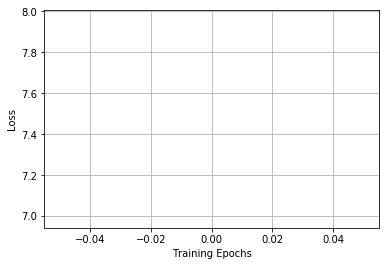

Epoch 0 - MAP: 0.21597675845720188
7.338903903961182
7.106348991394043
6.727352142333984
7.597296237945557
5.751609802246094
5.879537582397461
5.878917217254639
7.005219459533691
6.088039875030518
6.306798934936523
5.290521144866943
4.8629913330078125
5.728816032409668
4.446068286895752
5.243546485900879
6.29259729385376
5.545169830322266
6.198244094848633
5.263240814208984
6.32937479019165
6.002409934997559
6.763175964355469
7.384878158569336
5.5732421875
5.530154705047607
6.066964626312256
6.306163311004639
6.178071975708008
7.522094249725342
7.687152862548828
6.702733993530273
5.393407344818115
6.756742477416992
6.440693378448486
5.241475582122803
6.886433124542236
6.19310998916626
5.508406639099121
7.360740661621094
6.695916652679443
6.741285800933838
6.338762283325195
6.675778388977051
6.786555290222168
7.320239543914795
4.785071849822998
7.695207595825195
6.8162665367126465
6.253459930419922
5.388628005981445
5.915372848510742
5.677870273590088
7.049386501312256
6.799116134643555

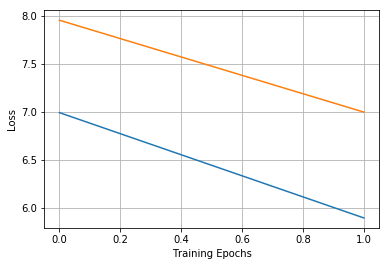

Epoch 1 - MAP: 0.22576274149708622
6.243584632873535
5.078003883361816
6.637452125549316
7.698478698730469
6.145238876342773
6.128952980041504
5.989891529083252
5.589839935302734
5.520360946655273
4.975825309753418
4.946646213531494
5.442999362945557
6.082945346832275
5.649330139160156
5.5723395347595215
6.160401344299316
4.711475372314453
5.2160773277282715
5.634033679962158
5.542508602142334
6.381950855255127
5.682382583618164
4.738493919372559
4.109805107116699
5.575272560119629
5.972006320953369
5.323816299438477
5.457457542419434
4.8711628913879395
4.577676296234131
5.1306376457214355
5.420464038848877
5.158143997192383
6.184590816497803
5.8673930168151855
6.181776523590088
4.468741416931152
4.369279861450195
4.803108215332031
6.000608444213867
4.917109966278076
6.437753677368164
6.692594051361084
5.20341682434082
5.084439754486084
5.651993751525879
5.022632122039795
7.305484771728516
5.58084774017334
3.928269863128662
4.848850250244141
4.640997409820557
6.471383571624756
6.049474

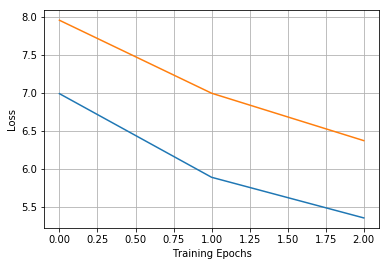

Epoch 2 - MAP: 0.24262478990247335
4.511319160461426
4.657161712646484
4.047098636627197
6.034989356994629
5.735626697540283
3.8223459720611572
6.466089248657227
4.874184608459473
5.18223237991333
5.4511003494262695
5.269967555999756
4.702964782714844
5.937573432922363
4.484434127807617
4.143612861633301
4.750146389007568
4.803539276123047
5.110729694366455
4.434591293334961
5.174525737762451
4.844808101654053
4.429134368896484
4.577341079711914
4.3905487060546875
5.111757278442383
5.711430072784424
4.840937614440918
5.4175944328308105
5.779982089996338
4.094501495361328
3.701444387435913
4.4355058670043945
5.30886697769165
4.7775421142578125
5.399509429931641
5.731707572937012
4.668462753295898
4.971127510070801
5.298884868621826
5.716170310974121
3.8602523803710938
5.230965614318848
4.234962463378906
5.011844635009766
5.895344257354736
4.886386871337891
5.779345512390137
6.019581317901611
3.625782012939453
4.24428129196167
4.388919353485107
4.0510759353637695
5.724616050720215
5.1844

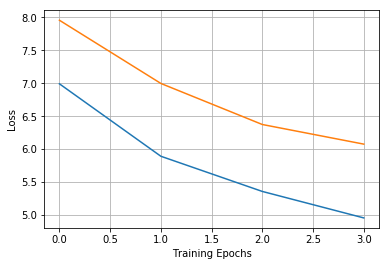

Epoch 3 - MAP: 0.2573866547431425
4.48787260055542
5.151417255401611
5.402679443359375
4.699382781982422
4.108150005340576
4.425891399383545
3.783107280731201
4.748328685760498
5.49200439453125
4.8668622970581055
5.1201066970825195
4.87893009185791
4.028568267822266
5.140810012817383
5.032907009124756
5.1515793800354
4.358391284942627
4.723627090454102
5.378706932067871
5.590112209320068
4.682901859283447
5.130122661590576
4.788662433624268
4.689115524291992
4.7843475341796875
4.395883560180664
3.710085391998291
4.4511332511901855
4.445551872253418
4.716215133666992
5.027512073516846
4.830668926239014
5.339370250701904
3.590773582458496
4.016983509063721
5.089848041534424
4.338778018951416
5.548287391662598
4.0124406814575195
5.320288181304932
3.629024028778076
4.614627838134766
5.033110618591309
4.6354146003723145
4.151682376861572
4.636775970458984
4.4411940574646
3.998053550720215
4.541469097137451
3.202407121658325
3.5268588066101074
4.592125415802002
4.834884166717529
3.8041863441

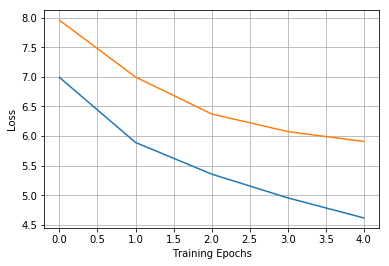

Epoch 4 - MAP: 0.26880800618725975
4.85353422164917
3.696235179901123
3.8232104778289795
4.210663795471191
4.657151222229004
4.133551120758057
4.177041053771973
5.256815433502197
4.803337574005127
4.514620780944824
4.7477288246154785
4.479828357696533
3.9593639373779297
4.365573406219482
4.523147106170654
4.997138977050781
4.139156818389893
4.27775239944458
3.8373496532440186
4.384584426879883
4.085784435272217
4.3581438064575195
3.2559921741485596
4.5603156089782715
5.04739236831665
4.8271894454956055
4.167529582977295
4.793524265289307
3.431628942489624
4.377294063568115
4.98299503326416
5.061666488647461
4.312937259674072
3.7104368209838867
3.659039258956909
3.6320226192474365
4.830268383026123
5.007072925567627
3.814167022705078
3.4128479957580566
3.373119592666626
3.97589111328125
3.4218270778656006
4.010858058929443
3.2288460731506348
3.433541774749756
4.7452616691589355
3.6684789657592773
3.676809549331665
4.608355522155762
4.189504146575928
4.435404300689697
4.940980911254883
4

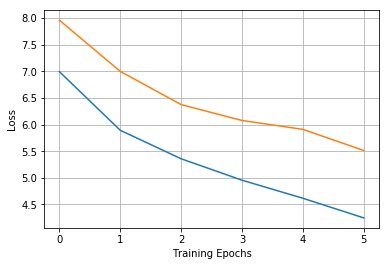

Epoch 5 - MAP: 0.29121154518970804
3.17043399810791
2.9350016117095947
3.5226950645446777
3.191922426223755
4.008012294769287
3.738858222961426
3.765594005584717
4.007194995880127
3.6859583854675293
3.574151039123535
3.146775960922241
3.8857882022857666
3.7272493839263916
3.7117936611175537
3.7727270126342773
3.6896657943725586
4.458489418029785
3.657227039337158
3.287177562713623
4.366675853729248
4.513791561126709
3.153412103652954
3.8039181232452393
3.9741907119750977
4.413081169128418
3.038752555847168
4.301466941833496
4.551314353942871
4.051590919494629
4.254687786102295
3.437622308731079
4.560087203979492
3.8635494709014893
3.6994690895080566
4.0667805671691895
3.43791127204895
4.385865211486816
3.949031114578247
4.028762340545654
3.1248152256011963
4.038296699523926
3.2306017875671387
3.294049024581909
4.167789936065674
2.940333366394043
3.416898727416992
3.39308500289917
3.730264902114868
3.549381732940674
5.015481472015381
3.7051215171813965
4.4314961433410645
3.8613147735595

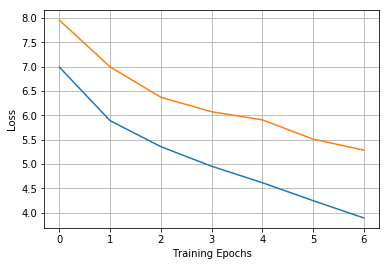

Epoch 6 - MAP: 0.2802246024131392
2.9295690059661865
3.8176891803741455
3.243232250213623
3.49804949760437
3.387045383453369
3.6500372886657715
3.595623016357422
4.5188398361206055
3.694859743118286
3.4212658405303955
3.323026657104492
3.2723262310028076
4.220809459686279
3.561997413635254
3.456972122192383
3.3759379386901855
3.620119571685791
3.0401313304901123
4.154657363891602
3.0868642330169678
3.922295331954956
3.303250789642334
5.19977331161499
3.653583526611328
4.132141590118408
4.01984977722168
2.9936068058013916
3.014169216156006
4.089113235473633
3.258498191833496
3.1221683025360107
3.394951343536377
3.5145277976989746
5.1695427894592285
3.707904815673828
3.023484945297241
3.463815927505493
3.9831743240356445
4.311144828796387
3.150007486343384
3.270061492919922
3.357032537460327
4.179505348205566
3.9251396656036377
2.357637405395508
3.75224232673645
3.0498769283294678
3.509521961212158
3.5417733192443848
3.2654292583465576
2.4930152893066406
3.3098506927490234
3.419585227966

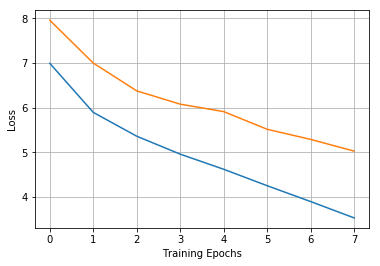

Epoch 7 - MAP: 0.3189484950675417
3.1096956729888916
3.6430623531341553
2.405351400375366
2.2865653038024902
3.1649537086486816
3.684666395187378
3.5039544105529785
2.858882188796997
2.2204039096832275
2.6646687984466553
2.54782772064209
3.322643756866455
3.2491202354431152
4.026251316070557
3.822303295135498
2.732898712158203
3.501481771469116
2.568901538848877
2.697514057159424
3.5012433528900146
2.6019983291625977
3.0763349533081055
3.3927714824676514
3.192781448364258
3.12593674659729
2.5676939487457275
2.8766262531280518
3.5885114669799805
2.304515838623047
3.603381633758545
2.6846911907196045
3.063013792037964
2.6232616901397705
2.9681921005249023
3.2924792766571045
2.685331106185913
3.7352588176727295
2.859983444213867
2.441155433654785
3.6302058696746826
2.3263094425201416
2.4909510612487793
3.203993558883667
3.4851295948028564
2.6574347019195557
3.128486156463623
3.247563362121582
3.074535846710205
2.348903179168701
2.3453543186187744
3.6709017753601074
3.361076593399048
3.427

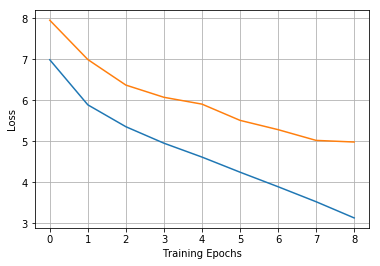

Epoch 8 - MAP: 0.34894651323412434
3.21130633354187
2.216484785079956
2.7575674057006836
2.8286139965057373
2.4864003658294678
2.6853551864624023
3.048992156982422
2.258200168609619
2.8487236499786377
2.6716575622558594
2.633864402770996
2.553040027618408
3.296274423599243
2.168778896331787
2.862722396850586
3.513472318649292
2.783670663833618
2.74989914894104
3.205725908279419
2.642817735671997
2.3714637756347656
1.8503469228744507
2.79006290435791
2.709991693496704
3.0335440635681152
2.594945192337036
2.859680652618408
3.412409782409668
2.998526096343994
3.6508474349975586
3.3669071197509766
3.053964853286743
2.496143102645874
2.3037047386169434
2.0232620239257812
3.1271345615386963
2.754977226257324
2.8371760845184326
1.6606980562210083
3.2085776329040527
2.0528218746185303
2.237855911254883
2.074697732925415
3.3346750736236572
2.8892366886138916
2.9347100257873535
2.3187143802642822
2.1018285751342773
2.4628891944885254
2.7082998752593994
3.018045425415039
2.137769937515259
2.60587

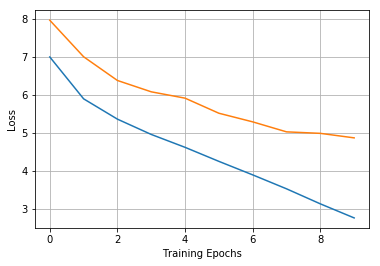

Epoch 9 - MAP: 0.3816741450522412
2.542771577835083
2.508665084838867
2.086007595062256
2.2612364292144775
2.2935845851898193
2.123349189758301
2.5442707538604736
2.4448893070220947
2.5096428394317627
2.265596389770508
2.1805083751678467
2.531155586242676
2.2563579082489014
2.558924436569214
2.4498167037963867
2.1048836708068848
2.1623446941375732
2.7295782566070557
1.835622787475586
2.299217462539673
2.242072582244873
2.418797492980957
2.4019980430603027
3.320167064666748
2.815504550933838
2.146235466003418
2.491924524307251
1.996856689453125
2.235887289047241
2.072985887527466
2.6522915363311768
2.599632740020752
2.1938374042510986
2.306654453277588
2.8407506942749023
2.4614245891571045
2.0416855812072754
2.543600559234619
2.1449661254882812
2.1752398014068604
1.6880565881729126
2.4555017948150635
2.297802686691284
2.1902902126312256
2.3796746730804443
2.4861185550689697
2.06329345703125
2.2427306175231934
3.1172566413879395
2.1398212909698486
2.2894787788391113
1.907794713973999
2.0

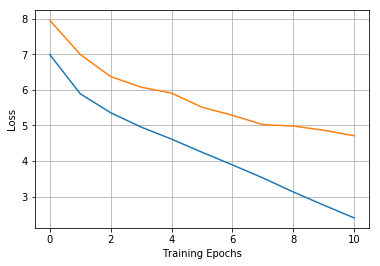

Epoch 10 - MAP: 0.39777483833128563
1.9321202039718628
1.8781778812408447
1.9907146692276
2.0693211555480957
2.180140256881714
2.316314458847046
1.6336520910263062
2.0242230892181396
2.2630443572998047
1.9406721591949463
2.099902868270874
1.5520710945129395
1.7660001516342163
1.8774927854537964
2.5531914234161377
1.852458119392395
2.2077128887176514
1.751275897026062
2.283829689025879
2.043032169342041
2.4117209911346436
2.2747292518615723
2.295841932296753
2.4718496799468994
2.273313045501709
2.0461905002593994
1.9665374755859375
1.9259074926376343
2.5969059467315674
2.4671332836151123
1.734514832496643
1.7899125814437866
2.2927331924438477
2.701800584793091
2.4168763160705566
1.915689468383789
1.6182962656021118
2.0151689052581787
1.874925971031189
3.368931531906128
1.7696001529693604
2.0507383346557617
1.9505772590637207
2.656564474105835
2.148361921310425
2.1393868923187256
2.0882108211517334
1.9000810384750366
1.8610161542892456
1.8960027694702148
2.1112632751464844
2.270182847976

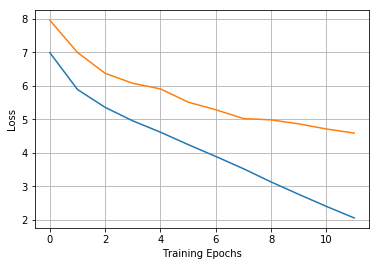

Epoch 11 - MAP: 0.43977190969893043
1.5340360403060913
1.4824405908584595
1.543479561805725
1.8586715459823608
1.2214876413345337
1.8228884935379028
2.157521963119507
1.6856446266174316
1.455769658088684
2.003659248352051
1.7586036920547485
1.8991490602493286
1.6311063766479492
1.8463850021362305
1.4379756450653076
1.5867613554000854
1.9771796464920044
1.7228918075561523
1.590965986251831
2.425736427307129
1.7385739088058472
1.331835389137268
1.612939715385437
1.5298553705215454
1.4527714252471924
1.8647403717041016
1.2220927476882935
1.8623143434524536
1.4562183618545532
1.2497707605361938
2.1053953170776367
1.1620852947235107
1.7073856592178345
2.1739602088928223
1.531874179840088
2.3838276863098145
1.4775370359420776
1.2756068706512451
1.1085789203643799
1.801931381225586
1.539143681526184
1.6685638427734375
1.9917418956756592
1.8270546197891235
1.6285104751586914
1.612739086151123
1.0977522134780884
1.729569435119629
1.5311845541000366
1.5301352739334106
2.523303747177124
1.6803789

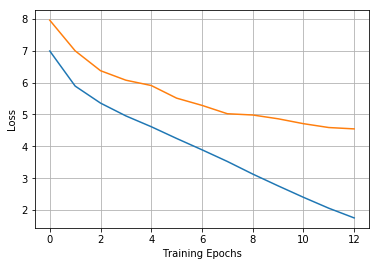

Epoch 12 - MAP: 0.45032382631960205
1.2893232107162476
1.4409548044204712
1.4216160774230957
1.6656790971755981
1.6229809522628784
1.764922022819519
0.9095652103424072
1.6660571098327637
1.0881526470184326
1.620092749595642
1.2728959321975708
2.0528104305267334
1.4225258827209473
1.675795555114746
1.439597725868225
1.3529671430587769
1.4450950622558594
1.7984260320663452
1.5189521312713623
1.5957931280136108
1.7324937582015991
1.641151785850525
1.778891682624817
1.5229066610336304
1.6877906322479248
1.6852288246154785
1.8021252155303955
1.2354378700256348
1.7853162288665771
1.509118914604187
1.8939059972763062
1.705573320388794
1.8582913875579834
1.528698205947876
1.6018717288970947
1.7904800176620483
1.1615482568740845
2.004620313644409
0.9711407423019409
1.7867217063903809
1.1723384857177734
1.6648807525634766
1.0723326206207275
1.2691240310668945
1.6128000020980835
1.6657016277313232
1.0598468780517578
1.0766613483428955
1.3673642873764038
1.5488121509552002
1.3301434516906738
1.442

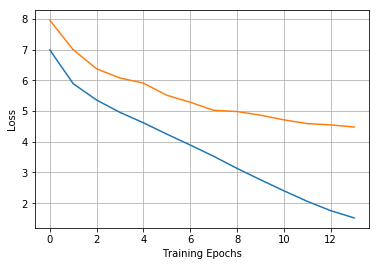

Epoch 13 - MAP: 0.45586458974858796
1.3007488250732422
1.3707473278045654
1.3931536674499512
0.9692934155464172
1.0668573379516602
1.086629033088684
1.2608089447021484
1.4185917377471924
1.2114521265029907
1.121006727218628
1.2884790897369385
1.255570650100708
0.8819617033004761
1.5644258260726929
2.0264828205108643
1.4047998189926147
1.2352694272994995
1.000876545906067
0.926845371723175
1.2228249311447144
1.3605231046676636
1.1934690475463867
1.4664037227630615
1.2637161016464233
1.3907533884048462
1.7755964994430542
1.047257423400879
1.504201889038086
1.171768307685852
1.5438257455825806
1.2109063863754272
1.8318077325820923
1.0508248805999756
1.335844874382019
0.8502639532089233
1.6734504699707031
1.4614773988723755
1.2477089166641235
1.5453351736068726
1.4388262033462524
1.1801825761795044
1.0646973848342896
1.6031492948532104
1.2412497997283936
1.4852616786956787
1.0012149810791016
0.911838948726654
1.289368987083435
1.4178502559661865
1.4305707216262817
1.05064857006073
0.874124

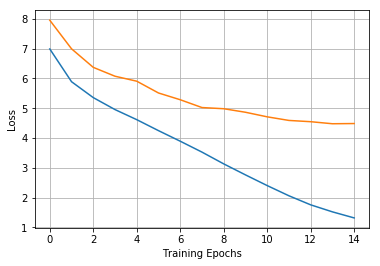

Epoch 14 - MAP: 0.4976052605665739
1.5309600830078125
1.084833025932312
0.8439825177192688
1.134031057357788
1.220206618309021
1.3738120794296265
1.2798571586608887
1.1715950965881348
1.4147701263427734
0.7511690258979797
0.9690526127815247
1.2307530641555786
0.960294783115387
1.310780644416809
1.503997802734375
1.4468251466751099
1.4933159351348877
1.1443716287612915
1.0979297161102295
1.109971523284912
1.2141568660736084
1.3059927225112915
1.393079161643982
0.8690926432609558
1.1220163106918335
1.0298150777816772
1.1492960453033447
0.8585250377655029
1.0242975950241089
1.0924084186553955
0.9792969822883606
0.8379660248756409
0.9447494149208069
0.7405456900596619
0.7932230830192566
0.7617089748382568
1.2982653379440308
1.016823410987854
1.219669222831726
1.1765389442443848
1.1170523166656494
0.8716803193092346
1.265328288078308
1.4110301733016968
0.9924085140228271
1.469028353691101
1.264557123184204
1.299546241760254
1.1618391275405884
1.3318016529083252
1.1052465438842773
0.90261614

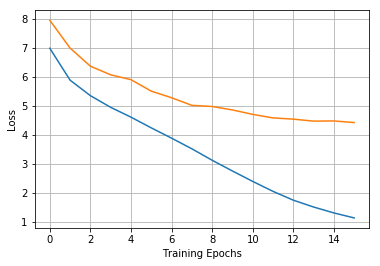

Epoch 15 - MAP: 0.4912492347058287
0.7700985670089722
0.5489607453346252
0.6539198756217957
1.0885342359542847
0.8962904214859009
1.4158778190612793
0.8780906796455383
0.7931699156761169
0.8875998854637146
0.9995312690734863
1.0301568508148193
1.0229324102401733
1.1880316734313965
0.9757164120674133
0.9067260026931763
1.0617470741271973
0.5657089352607727
0.8152653574943542
0.8774036169052124
0.81178879737854
0.7966325283050537
0.8230182528495789
0.9712632298469543
0.8035456538200378
0.9048471450805664
1.1721972227096558
0.8787592053413391
1.322574257850647
1.2890517711639404
1.0460039377212524
0.9660986661911011
1.2821558713912964
1.180612325668335
0.8733489513397217
0.6246030330657959
0.6152995228767395
1.0260099172592163
1.3387643098831177
0.9217986464500427
0.9162434339523315
0.6969801187515259
0.8296898603439331
1.1654332876205444
1.518426537513733
1.0484139919281006
1.2485936880111694
1.1852234601974487
0.8989690542221069
1.105845332145691
1.3416014909744263
1.0690200328826904
0.

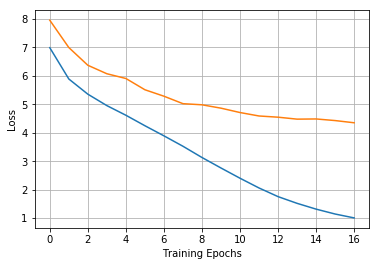

Epoch 16 - MAP: 0.4897218842039172
1.0338762998580933
0.6695488691329956
0.9570353627204895
1.1940430402755737
1.160652756690979
0.9211690425872803
0.8333672881126404
0.870223343372345
0.9215074777603149
0.7356533408164978
0.8709666132926941
0.6385313272476196
0.8265249133110046
0.967829167842865
0.662972092628479
0.7820946574211121
0.7596449851989746
0.9390857815742493
0.8987794518470764
0.7456334233283997
0.6038376092910767
0.7958300709724426
0.8028616309165955
0.734540581703186
1.246472954750061
0.9715244770050049
0.9290327429771423
0.7193077206611633
0.8190672993659973
0.6168010234832764
1.1462440490722656
0.8090217113494873
0.7644482254981995
0.7290804386138916
0.9996704459190369
1.0038509368896484
1.215607762336731
0.5247552990913391
0.8198234438896179
1.0351446866989136
1.0834680795669556
0.9977797865867615
0.9291830062866211
0.9369580149650574
0.9024999141693115
0.7544986009597778
0.5341446399688721
1.2832460403442383
0.7084010243415833
0.9893618822097778
0.9709620475769043
0.8

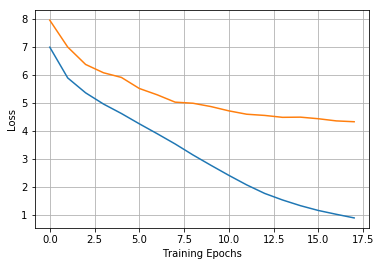

Epoch 17 - MAP: 0.5029402272614667
1.0061429738998413
0.5645179748535156
0.5220340490341187
0.7075929641723633
1.047568917274475
0.8549094200134277
0.7156052589416504
0.7978476285934448
0.6983712911605835
0.6929381489753723
0.7481523156166077
0.6604913473129272
0.4915430545806885
1.1007496118545532
0.5735815763473511
0.786312997341156
0.813449501991272
0.683477520942688
0.7747499346733093
0.9576008915901184
0.577200710773468
0.6261487603187561
0.7039442658424377
0.8866104483604431
0.6376420259475708
0.9496689438819885
0.742033839225769
0.792959451675415
1.0482257604599
0.7982844114303589
0.6719314455986023
0.7249159216880798
0.5243822932243347
0.9247592091560364
0.7923258543014526
0.590842068195343
0.6619099974632263
0.6827765107154846
0.94489586353302
0.8740100860595703
0.7038807272911072
0.5175831913948059
0.6905471682548523
0.6189739108085632
0.8711475729942322
0.6665980219841003
0.9537675976753235
1.1410000324249268
0.5897294282913208
0.8037077784538269
0.9223942756652832
0.8986784

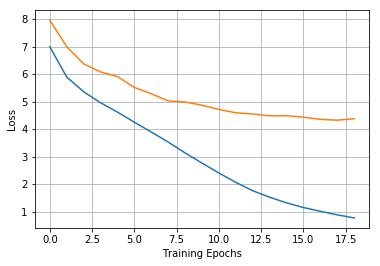

Epoch 18 - MAP: 0.5269178385296291
0.8659501671791077
0.7095097899436951
0.5956568121910095
0.948992133140564
0.3916260898113251
0.9012779593467712
0.6127755641937256
0.6575535535812378
0.5020822286605835
0.8110944628715515
0.6897011399269104
0.5821429491043091
0.4936603009700775
0.6951156258583069
0.8169870972633362
0.6861904859542847
1.0358930826187134
0.5080605745315552
0.7740662693977356
0.48197412490844727
0.6345438361167908
0.6282380223274231
0.7916439771652222
0.8615210652351379
0.6240248084068298
0.38475552201271057
0.5324569344520569
0.5988231897354126
0.5071181058883667
0.6742377877235413
0.9638509154319763
1.036525845527649
0.8008890748023987
0.5135071873664856
0.9052867889404297
0.504878580570221
0.5554142594337463
0.6615171432495117
0.7890180945396423
0.8702972531318665
0.63957679271698
0.7142276167869568
0.581028163433075
0.4850088059902191
0.5215756297111511
0.6935176849365234
0.44135773181915283
0.5967077016830444
0.5477155447006226
0.773813009262085
0.633610188961029
0

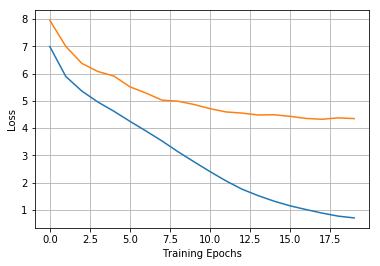

Epoch 19 - MAP: 0.5483689923310706
0.6968028545379639
0.6511440277099609
0.7545633912086487
0.743657648563385
0.7228966355323792
0.516233503818512
0.6710661053657532
0.519209086894989
0.7716947197914124
0.7041860222816467
0.4809558093547821
0.5438448190689087
0.526960551738739
0.7634148597717285
0.9911360144615173
0.6201451420783997
0.5092642307281494
0.7881144881248474
0.41875335574150085
0.5251711010932922
0.6253857612609863
0.6109504103660583
0.8559138178825378
0.7704949975013733
0.4982092082500458
0.4462709426879883
0.5502108931541443
0.5437034964561462
0.7879551649093628
0.6125114560127258
0.7231191992759705
0.534323513507843
0.6644195914268494
0.2772260308265686
0.6815640330314636
0.46098995208740234
0.5795347094535828
0.4897262752056122
0.3821403384208679
0.9488305449485779
0.49887093901634216
0.6785258650779724
0.5634387731552124
0.5994164347648621
0.5713410377502441
0.7529289126396179
0.5884323716163635
0.34687137603759766
0.9954840540885925
0.7595731019973755
0.56685590744018

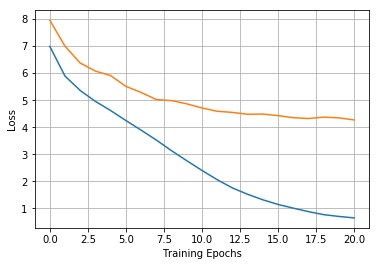

Epoch 20 - MAP: 0.5408076254018024
0.6514764428138733
0.6876387000083923
0.8105097413063049
0.47991371154785156
0.5945767760276794
0.7771319150924683
0.6204861402511597
0.6416280269622803
0.5288267135620117
0.5537980198860168
0.9939668774604797
0.5797334909439087
0.3447629511356354
0.4739825129508972
0.48728227615356445
0.41781502962112427
0.7338554859161377
0.37266775965690613
0.6277567744255066
0.44287821650505066
0.39350423216819763
0.7101688385009766
0.35591378808021545
0.6908130645751953
0.3595268726348877
0.381706565618515
0.36106064915657043
0.5049460530281067
0.5329856872558594
0.5597139596939087
0.7975319027900696
0.6399124264717102
0.4861224889755249
0.672997772693634
0.6987712979316711
0.6259048581123352
0.528069257736206
0.5210684537887573
0.4135299026966095
0.5451270937919617
0.5747900605201721
0.5210309624671936
0.9981980323791504
0.7231392860412598
0.5264023542404175
0.6702289581298828
0.724316418170929
0.7725270390510559
0.663381814956665
0.42143484950065613
0.678277254

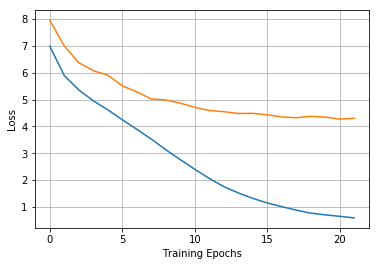

Epoch 21 - MAP: 0.5506803917339002
0.7310655117034912
0.39130765199661255
0.41896557807922363
0.5482533574104309
0.40465661883354187
0.37516796588897705
0.9194536805152893
0.6352477669715881
0.6578689217567444
0.4876994788646698
0.45042720437049866
0.44027259945869446
0.37100672721862793
0.4401155114173889
0.7067808508872986
0.37424424290657043
0.48302358388900757
0.5852730870246887
0.6693045496940613
0.3808380961418152
0.5533686876296997
0.5346757173538208
0.5278086066246033
0.4804579019546509
0.454395055770874
0.40433141589164734
0.5304628014564514
0.4089435040950775
0.7351287007331848
0.6225908994674683
0.698346734046936
0.42996105551719666
0.4782079756259918
0.32610011100769043
0.6142981052398682
0.6170839667320251
0.4220842719078064
0.40260061621665955
0.5700304508209229
0.6152724623680115
0.5545145273208618
0.6934689283370972
0.7919005751609802
0.6894484758377075
0.8542318344116211
0.4754556119441986
0.7404699921607971
0.6406623125076294
0.4623761475086212
0.6769022941589355
0.31

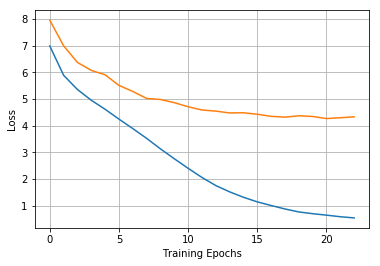

Epoch 22 - MAP: 0.5511130031398914
0.5019825100898743
0.41692137718200684
0.5695116519927979
0.5332194566726685
0.7982522249221802
0.49808287620544434
0.47279617190361023
0.378813773393631
0.42999333143234253
0.80765300989151
0.3685036897659302
0.40303024649620056
0.3003600835800171
0.6008439660072327
0.7762990593910217
0.47280821204185486
0.37684252858161926
0.3668960630893707
0.5032787919044495
0.6328551769256592
0.49806392192840576
0.665398359298706
0.777683436870575
0.41330453753471375
0.4912174344062805
0.4464028477668762
0.4721548557281494
0.3841097950935364
0.47404858469963074
0.676957905292511
0.32178783416748047
0.5040188431739807
0.6313570737838745
0.7127893567085266
0.41028279066085815
0.3769723176956177
0.7441405653953552
0.6382128596305847
0.52891606092453
0.4319421052932739
0.6741642951965332
0.3505890965461731
0.6040671467781067
0.6890069842338562
0.8089087605476379
0.4763754606246948
0.4641388952732086
0.3492512106895447
0.6125002503395081
0.5171140432357788
0.425748676

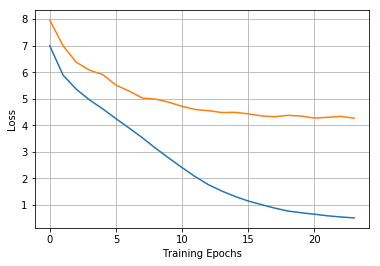

Epoch 23 - MAP: 0.5645088439911863
0.4486488699913025
0.28276529908180237
0.46945464611053467
0.531548261642456
0.6458168625831604
0.4426085650920868
0.7390555739402771
0.5398960113525391
0.4639083743095398
0.4543954133987427
0.3595238924026489
0.37471804022789
0.5651284456253052
0.49191105365753174
0.8665280938148499
0.44770076870918274
0.6814804077148438
0.35501107573509216
0.3728736937046051
0.4556888937950134
0.572457492351532
0.584104597568512
0.664533793926239
0.4310097396373749
0.46252453327178955
0.4372955560684204
0.5031003952026367
0.6966997385025024
0.5517200827598572
0.7097770571708679
0.34536078572273254
0.48897454142570496
0.2642441987991333
0.5049889087677002
0.5423404574394226
0.36111435294151306
0.5131638050079346
0.45135074853897095
0.41133594512939453
0.39475882053375244
0.6028892993927002
0.540600597858429
0.42954835295677185
0.43073225021362305
0.48957985639572144
0.5540030598640442
0.48766207695007324
0.4265515208244324
0.3199419379234314
0.5175949931144714
0.4033

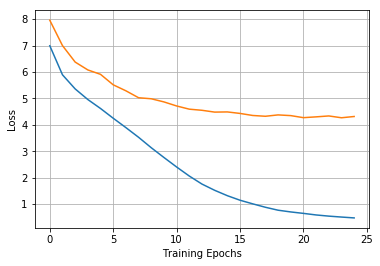

Epoch 24 - MAP: 0.5682715262709117
0.6315975189208984
0.32358455657958984
0.3122310936450958
0.45606887340545654
0.361075758934021
0.5915125608444214
0.38346999883651733
0.38729146122932434
0.27006426453590393
0.356675922870636
0.4946270287036896
0.5003729462623596
0.4489856958389282
0.3729132413864136
0.39034634828567505
0.3453419506549835
0.42368635535240173
0.43216097354888916
0.3304970860481262
0.523838460445404
0.47709953784942627
0.42819297313690186
0.4847496449947357
0.7058883309364319
0.3081793785095215
0.5257968902587891
0.33332058787345886
0.32150205969810486
0.27621012926101685
0.605469286441803
0.5743346214294434
0.5092089176177979
0.7829309701919556
0.4747575521469116
0.5016282796859741
0.3392985463142395
0.4511528015136719
0.41495028138160706
0.3147210478782654
0.3967849612236023
0.592059850692749
0.4275842010974884
0.5932216048240662
0.306647390127182
0.24388428032398224
0.5366731882095337
0.33170410990715027
0.4668876528739929
0.45707327127456665
0.29923173785209656
0.4

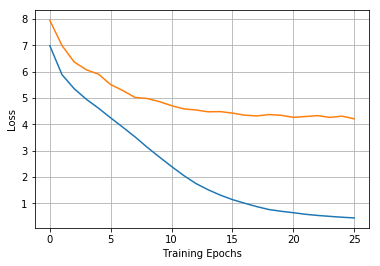

Epoch 25 - MAP: 0.5583412465699322
0.28435254096984863
0.3271694779396057
0.43380051851272583
0.5653428435325623
0.5237776041030884
0.3595324456691742
0.38139501214027405
0.39585283398628235
0.7350257039070129
0.37207311391830444
0.3827579617500305
0.28114449977874756
0.2766272723674774
0.3833926320075989
0.41842442750930786
0.2515751123428345
0.44773831963539124
0.33805975317955017
0.45952680706977844
0.46621784567832947
0.5653809905052185
0.3721114993095398
0.30842211842536926
0.6254213452339172
0.42042768001556396
0.32381537556648254
0.32893070578575134
0.4608571231365204
0.42937323451042175
0.3739192485809326
0.38046932220458984
0.5942992568016052
0.3269731104373932
0.47962483763694763
0.4741534888744354
0.5455490946769714
0.47792086005210876
0.3859338164329529
0.44344016909599304
0.2741272449493408
0.33637702465057373
0.4524209797382355
0.3614748418331146
0.5019186735153198
0.26795560121536255
0.3069837987422943
0.44140273332595825
0.4469636380672455
0.37172919511795044
0.55532771

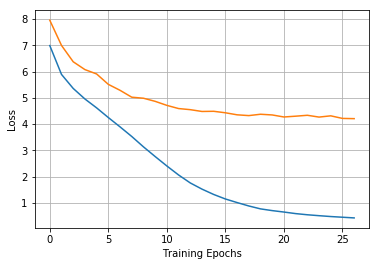

Epoch 26 - MAP: 0.5717876784130412
0.40050098299980164
0.1818549633026123
0.5698626041412354
0.4197579026222229
0.39904361963272095
0.29837602376937866
0.4633384644985199
0.6530226469039917
0.5296715497970581
0.5897276997566223
0.35600483417510986
0.26806557178497314
0.4722057282924652
0.29766181111335754
0.4293868839740753
0.4173680543899536
0.2843415141105652
0.3546081483364105
0.3996679484844208
0.5810644626617432
0.3456588387489319
0.3028715252876282
0.35433924198150635
0.2979513704776764
0.3455207347869873
0.6296273469924927
0.38832616806030273
0.624959409236908
0.25109684467315674
0.2406056970357895
0.3346678614616394
0.3864244222640991
0.314270555973053
0.632318913936615
0.6196177005767822
0.5088182091712952
0.4039938449859619
0.3558084964752197
0.8711245059967041
0.3527830243110657
0.3839903473854065
0.29633456468582153
0.7236689329147339
0.3685227334499359
0.2471708059310913
0.37422069907188416
0.7266435623168945
0.3921394944190979
0.46986302733421326
0.3439100682735443
0.4555

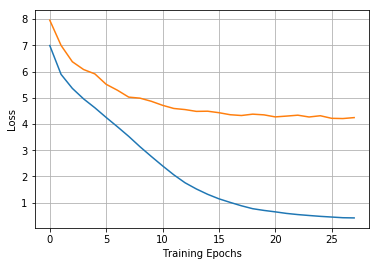

Epoch 27 - MAP: 0.5475295575913125
0.37933096289634705
0.4848373830318451
0.4742797315120697
0.36227917671203613
0.3201068341732025
0.5661178231239319
0.3435327708721161
0.22466693818569183
0.43111708760261536
0.3137395679950714
0.5060058832168579
0.5076178908348083
0.5599020719528198
0.2186644822359085
0.38091182708740234
0.6113693714141846
0.2775403559207916
0.35481470823287964
0.47018542885780334
0.43821802735328674
0.361595094203949
0.47310853004455566
0.27383506298065186
0.4212616980075836
0.2576816976070404
0.274748831987381
0.3269539475440979
0.6950083374977112
0.3560541272163391
0.45705169439315796
0.2340899109840393
0.4666869640350342
0.5989406108856201
0.3979126214981079
0.367737352848053
0.49011656641960144
0.44018277525901794
0.1877063512802124
0.4067322015762329
0.46309444308280945
0.5247918963432312
0.42214396595954895
0.5093131065368652
0.2304837703704834
0.2995060086250305
0.31657910346984863
0.47868749499320984
0.26759225130081177
0.2624702453613281
0.3702676594257355


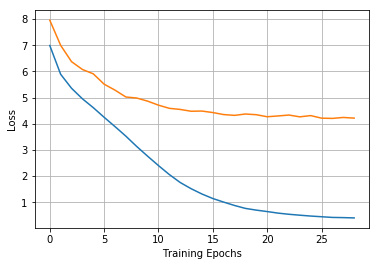

Epoch 28 - MAP: 0.5575037140425076
0.3522370159626007
0.5695812702178955
0.44299328327178955
0.4177602231502533
0.32423582673072815
0.4340061545372009
0.3394046127796173
0.2990940511226654
0.32970285415649414
0.552314281463623
0.34168779850006104
0.2999466359615326
0.4640454649925232
0.4271254241466522
0.21249251067638397
0.3067116439342499
0.4131520986557007
0.23626172542572021
0.40611743927001953
0.5114211440086365
0.472078412771225
0.48312196135520935
0.3281554579734802
0.6070736646652222
0.28746965527534485
0.3505837023258209
0.42436856031417847
0.6479772925376892
0.2683171033859253
0.47143590450286865
0.2530611455440521
0.5499445199966431
0.4384835660457611
0.35014522075653076
0.3382960259914398
0.27848854660987854
0.3257816433906555
0.38366204500198364
0.42672020196914673
0.34857937693595886
0.4007045328617096
0.3883817195892334
0.2921312153339386
0.4222630560398102
0.3085344135761261
0.35091638565063477
0.4490422308444977
0.4375121295452118
0.23710894584655762
0.2683573067188263

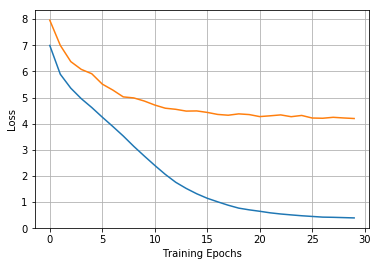

Epoch 29 - MAP: 0.5608000642298023


FileNotFoundError: ignored

In [192]:
lambda_coord = 5.0
lambda_noobj = 0.5
optimizer = optim.Adam(model.parameters(), lr = 0.005)

training_loss=[]
validation_loss = []
testing_map = []

epochs = 30

def plot_loss(training_loss, validation_loss):
  # plt.title("Loss vs. Number of Training Epochs")
  # plot_loss_list.append(loss)
  # plt.ion()
  plt.xlabel("Training Epochs")
  plt.ylabel("Loss")
  plt.plot(training_loss, label='Training loss')
  plt.plot(validation_loss, label='Validation loss')
  # plt.legend(frameon=False)
  plt.grid()
  plt.show()
  plt.pause(0.05)

for e in range(epochs):
    running_loss = 0.0
    running_map = 0

    # if e>10:
    #   optimizer = optim.Adam(model.parameters(), lr = 0.005)

    #Training
    for images, labels in trainloader:
        images,labels = images.to(device), labels.to(device)
        # print(images.shape,labels.shape)
        optimizer.zero_grad()        
        output = model(images)
        # print(output.shape)
        loss = myloss_fn(output,labels,lambda_coord,lambda_noobj)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(loss.item())
        
    # plt.show()
    training_loss.append(running_loss/len(trainloader))
    print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
    
    #Testing
    test_running_loss = 0.0
    test_running_map = 0.0
    for images,labels in testloader:
      images,labels = images.to(device), labels.to(device)
      with torch.no_grad():
        output = model(images)
        mean_avg_precision = postprocess_labels(output,labels)
        test_running_map += mean_avg_precision
        loss = myloss_fn(output, labels,lambda_coord,lambda_noobj)
        test_running_loss += loss.item()
        
    validation_loss.append(test_running_loss/len(testloader))
    print("Epoch {} - Validation loss: {}".format(e, test_running_loss/len(testloader)))
    plot_loss(training_loss,validation_loss)
    testing_map.append(test_running_map/len(testloader))
    print("Epoch {} - MAP: {}".format(e, test_running_map/len(testloader)))

torch.save(model.state_dict(), data_folder / 'yolo_6_2.pt')

Plot training and validation curves


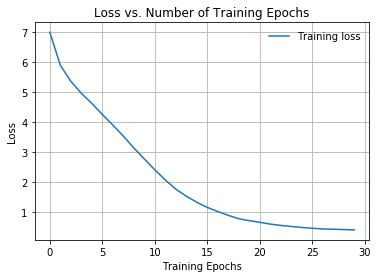

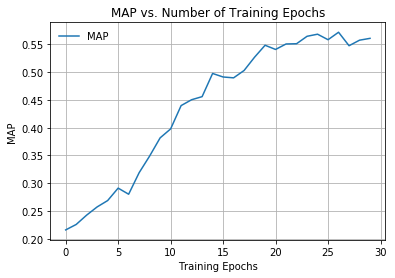

In [194]:
# Plot training and validation curves

# plt.figure(0)
# plt.title("Accuracy vs. Number of Training Epochs")
# plt.xlabel("Training Epochs")
# plt.ylabel("Accuracy")
# plt.plot(training_acc, label='Training Accuracy')
# plt.plot(validation_acc, label='Validation Accuracy')
# plt.legend(frameon=False)
# plt.grid()
# plt.show()

plt.figure()
plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(training_loss, label='Training loss')
# plt.plot(validation_loss, label='Validation loss')
plt.legend(frameon=False)
plt.grid()
plt.show()

plt.figure()
plt.title("MAP vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("MAP")
plt.plot(testing_map, label='MAP')
plt.legend(frameon=False)
plt.grid()
plt.show()


In [0]:
torch.save(model.state_dict(), data_folder / 'yolo_6_2.pt')


# Test your network

Did you remember to cut out a test set? If not you really should, test on images your network has never seen.

In [0]:
import cv2
import torchvision

def convert_yolo_box(x,y,w,h,grid_index):
  patch_size = 16
  image_shape = [128,128]
  
  i,j = grid_index

  w = w*image_shape[0]
  h = h*image_shape[1]
  x = x*patch_size
  y = y*patch_size

  box_center_x = i*patch_size + x
  box_center_y = j*patch_size + y
    
  x1 = int(box_center_x - 0.5*w)
  y1 = int(box_center_y - 0.5*h)
  x2 = int(box_center_x + 0.5*w)
  y2 = int(box_center_y + 0.5*h)
  
  # print(box_center_x, box_center_y,x1,y1,x2,y2)

  return x1,y1,x2,y2

def plot_boxes_img(tensor_image, tensor_label):
  
  img = tensor_image.permute(1,2,0).numpy().copy()
  labels = tensor_label.numpy()
  
  obj_indices = torch.nonzero(tensor_label[:,:,0]).numpy()
  
  for index in obj_indices:
    i,j = index
    # print(i,j)
    # print("Pr(Objectness) = {} ; x,y,w,h = [{},{},{},{}] ; Pr(pedestrian)={}, Pr(traffic_signal)={}, Pr(car)={} ".format(labels[i,j,0],labels[i,j,1],labels[i,j,2],labels[i,j,3],labels[i,j,4],labels[i,j,5],labels[i,j,6], labels[i,j,7]))
    x,y,w,h = labels[i,j,1:5].copy()
    x1,y1,x2,y2 = convert_yolo_box(x,y,w,h,index)

    object_class = np.argmax(labels[i,j,5:8])
    class_prob = labels[i,j,5+object_class]
    # print(object_class,class_prob)

    if object_class == 0:
      color = red
    elif object_class == 1:
      color = blue
    elif object_class == 2:
      color = green    
    # print(color)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 1)  
  
  return img

def compute_iou_bboxes(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
 
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
 
	# return the intersection over union value
	return iou

def postprocess_labels(pred_labels, gt_labels,images):
  grid_size = gt_labels.shape[1:3]
  
  batch = 0
  pred_boxes = []
  pred_boxes_scores = []
  pred_boxes_indices = []
  
  gt_img = plot_boxes_img(images[0].cpu(),gt_labels[0].cpu())

  pred_img_network = plot_boxes_img(images[0].cpu(),pred_labels[0].cpu())

  # Low Probability Suppression
  for i in range(grid_size[0]):
    for j in range(grid_size[1]):
      if(pred_labels[batch,i,j,0]<0.4):
        #removing boxes with low probability by making their P(Obj) = 0
        pred_labels[batch,i,j,0] = 0
        # pass  
      else:
        p,x,y,w,h = pred_labels[batch,i,j,0:5]
        index = [i,j]
        pred_boxes_indices.append(index)
        pred_boxes.append(list(convert_yolo_box(x,y,w,h,index)))
        pred_boxes_scores.append(p)

  pred_img_prob = plot_boxes_img(images[0].cpu(),pred_labels[0].cpu())
  
  #NMS with IOU>0.5
  nms_boxes_kept = torchvision.ops.nms(torch.tensor(pred_boxes,dtype=torch.float32),torch.tensor(pred_boxes_scores),0.5)
  # print(len(pred_boxes_scores), nms_boxes_kept)
  
  #removing boxes from NMS by making their P(Obj) = 0 
  for x,index in enumerate(pred_boxes_indices):
    if(not(x==nms_boxes_kept).any()):
      # print(x,nms_boxes_kept)
      i,j = index
      pred_labels[batch,i,j,0] = 0 

  pred_img_nms = plot_boxes_img(images[0].cpu(),pred_labels[0].cpu())
  
  precision,recall = compute_precision_recall(pred_labels,gt_labels)

  mean_avg_precision = compute_mean_avg_precision(precision,recall)

  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
  fig.suptitle('Inference Examples')
  ax1.set_title('Ground-Truth Labels')
  ax2.set_title('Network Predicted Labels')
  ax3.set_title('Low Probabilities Removed')
  # ax4.set_title('NMS with IoU>0.5 \n Precision={}, Recall={}'.format(round(precision,4),round(recall,4)))  
  ax4.set_title('NMS with IoU>0.5')    
  ax1.imshow(gt_img)
  ax2.imshow(pred_img_network)
  ax3.imshow(pred_img_prob)
  ax4.imshow(pred_img_nms)
  
  return mean_avg_precision

def compute_precision_recall(pred_labels, gt_labels):
  TP = FP = FN = 0
  precision = []
  recall = []

  grid_size = gt_labels.shape[1:3]
  pred_obj_indices = pred_labels[:,:,:,0].nonzero()
  gt_obj_indices = gt_labels[:,:,:,0].nonzero()

  gt_boxes_detected = []

  for index in pred_obj_indices:
    index = index.tolist()
    batch,i,j = index
    obj_class = torch.argmax(gt_labels[batch,i,j,5:8])
    # print("object_class = {}".format(obj_class))
    if(gt_labels[batch,i,j,0] == 0):
      FP += 1
    else:
      obj_not_previously_detected = index not in gt_boxes_detected

      obj_class_match = (torch.argmax(pred_labels[batch,i,j,5:8]) == obj_class)
      
      x,y,w,h = pred_labels[batch,i,j,1:5]
      pred_box = list(convert_yolo_box(x,y,w,h,[i,j]))
      x,y,w,h = gt_labels[batch,i,j,1:5]
      gt_box = list(convert_yolo_box(x,y,w,h,[i,j]))
      
      iou = compute_iou_bboxes(pred_box,gt_box)

      # print("class_match= {}, iou = {}".format(obj_class_match,iou))
      
      if obj_class_match and obj_not_previously_detected and iou>0.2:
        TP += 1
        gt_boxes_detected.append(index)
      else:
        FP += 1
        if obj_not_previously_detected == False:
          print("object previously detected")
        
    # OR just use this simple little trick
    FN = gt_obj_indices.shape[0] - TP
    
    # print("TP = {},FP = {}, FN = {}".format(TP,FP,FN))

    tmp_recall = TP/(TP+FN+0.001)
    tmp_precision = TP/(TP+FP+0.001)
    recall.append(tmp_recall)
    precision.append(tmp_precision)
    # print(tmp_recall)   

  # you could theoretically calculate false negatives like this-  
  # for index in gt_obj_indices:
  #   if(not(index==pred_obj_indices).any()):
  #     print(index,pred_obj_indices)
  #     FN+=1
  
  # print(precision,recall)
  return precision,recall

def compute_mean_avg_precision(precision,recall):
  interp_precision = []
  for i in range(11):
    step_point = i*0.1
    array = np.asarray(recall)
    array = (array - step_point)
    array[array < 0] = 1000
    if not(array==1000).all():
      idx = array.argmin()
      prev_max = max(precision[idx:])
      interp_precision.append(prev_max)
    else: 
      interp_precision.append(precision[-1])
  # print(interp_precision)
  mean_avg_precision = np.mean(np.asarray(interp_precision))
  return mean_avg_precision

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index of test image = 2381
MAP = 0.9997500624843788


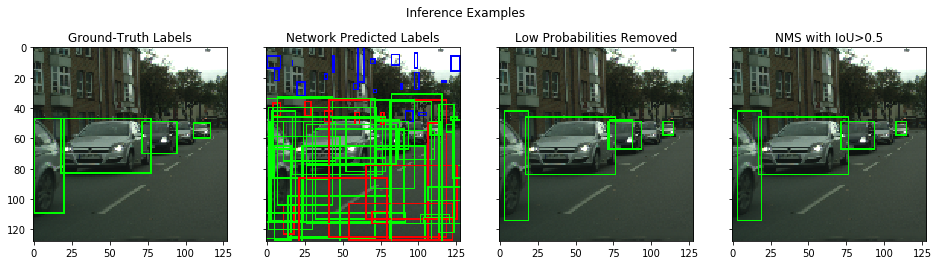

In [326]:
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = YOLOish().to(device)
model.load_state_dict(torch.load(data_folder / 'yolo_6_1.pt'))
model.eval()

lambda_coord,lambda_noobj = [5.0,0.5]

#Inference
index = random.randint(0,len(testset))
print("index of test image = {}".format(index))
image,gt_label = testset[index]
image,gt_label = image.to(device).unsqueeze(0), gt_label.to(device).unsqueeze(0)


with torch.no_grad():
  output = model(image)
  mean_avg_precision = postprocess_labels(output,gt_label,image)
  print("MAP = {}".format(mean_avg_precision))